## MARBL diagnostics for ocean history files, box region averages: 

### Case: g.e30b06.GW1850MARBL_JRA.new_fesedflux.002


In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import utils
import pandas as pd
import pop_tools
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

### Define case

In [3]:
case = 'g.e30b06.GW1850MARBL_JRA.new_fesedflux.002'
user = 'mlevy'

## Define the year range to examine and get the CESM history files

In [4]:
start_yr = 11
num_years = 10
endyr = start_yr + num_years 

#### first get the 3-D variables

In [5]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 11 !
doing simulation year 12 !
doing simulation year 13 !
doing simulation year 14 !
doing simulation year 15 !
doing simulation year 16 !
doing simulation year 17 !
doing simulation year 18 !
doing simulation year 19 !
doing simulation year 20 !


In [6]:
cesm_mon_ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

#### Now grab the 2-D variables

In [7]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 11 !
doing simulation year 12 !
doing simulation year 13 !
doing simulation year 14 !
doing simulation year 15 !
doing simulation year 16 !
doing simulation year 17 !
doing simulation year 18 !
doing simulation year 19 !
doing simulation year 20 !


In [8]:
cesm_mon_ds2 = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Keep only the variables we need (use this list for both 2-D and 3-D datasets)

In [9]:
variables2d = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','POC_FLUX_100m',
             'x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'ECOSYS_IFRAC','FG_CO2'] 

variables3d = ['SiO2_PROD','coccoCaCO3','diatC', 'coccoC','spC','diazC',
               #'diatN', 'coccoN','spN','diazN',
             'PO4','Fe','NO3','SiO3','O2','ALK',
            'microzooC','mesozooC','diaz_Nfix',
            'spChl','diatChl','diazChl','coccoChl','so','DIC','thetao'] 


coords = {'x':'yh','y':'xh'}

In [10]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keepthese])

In [11]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables2d + list(coords.values())
cesm_mon_ds2 = cesm_mon_ds2.drop([v for v in cesm_mon_ds2.variables if v not in keepthese])

## Get the grid data for MOM6

In [12]:
ds_grid = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e23b16.TL319_t232.GIAFMARBL.001.mom6.h.static.nc')

In [13]:
lons = ds_grid.geolon
lats = ds_grid.geolat
area = ds_grid.areacello #m2
lons_norm = utils.normal_lons(lons)
xlen = len(ds_grid.xh)
ylen = len(ds_grid.yh)

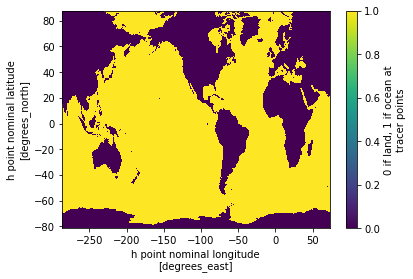

In [14]:
ds_grid.wet.plot()

#### Make my own dz variable

In [15]:
dz = np.zeros([34])

i = 0

for int in cesm_mon_ds.z_i.values[1:35]:
    
    level_up = cesm_mon_ds.z_i.values[i]
    #print(level_up,int)
    dz[i] = int - level_up

    i = i + 1

dz = xr.DataArray(dz,dims=('z_l'))

### spin up a bit of dask

In [16]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [17]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Client Scheduler: tcp://128.117.208.173:39631 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Make the annual mean

In [18]:
cesm_ann_ds = cesm_mon_ds.mean(dim='time', keep_attrs=True).compute()

In [19]:
cesm_ann_ds2 = cesm_mon_ds2.mean(dim='time', keep_attrs=True).compute()

### Turn the monthly ds into a climatology

In [20]:
cesm_mon_ds = cesm_mon_ds.groupby('time.month').mean('time', keep_attrs=True)

In [21]:
cesm_mon_ds2 = cesm_mon_ds2.groupby('time.month').mean('time', keep_attrs=True)

In [22]:
area_depth = area.where(cesm_ann_ds.ALK > 0)

### Define boxes

In [23]:
ones = np.full((ylen,xlen),1,dtype=int)
ones = xr.DataArray(ones,dims=('yh','xh'))
ones = ones.where(ds_grid.wet>0)


### CA current
box1_latmin = 35
box1_latmax = 42
box1_lonmin = -127.
box1_lonmax = -122.

### Peruvian upwelling
box2_latmin = -15
box2_latmax = -5
box2_lonmin = -82
box2_lonmax = -75

### N Pacific gyre
box3_latmin = 20
box3_latmax = 25
box3_lonmin = -175
box3_lonmax = -170

### N Atlantic
box4_latmin = 50
box4_latmax = 60
box4_lonmin = -45
box4_lonmax = -35

### Indian Ocean
box5_latmin = -10
box5_latmax = 0
box5_lonmin = 45
box5_lonmax = 50

### Subantarctic Pacific Southern Ocean
box6_latmin = -55
box6_latmax = -45
box6_lonmin = -155
box6_lonmax = -145

### AP/Eastern Weddell
box7_latmin = -75
box7_latmax = -60
box7_lonmin = -60
box7_lonmax = -48

In [24]:
reg_name_dict = {'box1' : 'CA current',
                 'box2' : 'Peru upwelling',
                 'box3' : 'Subtropical N Pacific',
                 'box4' : 'N Atlantic',
                 'box5' : 'W Indian',
                 'box6' : 'Subantarctic Pacific',
                 'box7' : 'Antarctic Peninsula'
                }

In [25]:
reg_name_dict['box1']

'CA current'

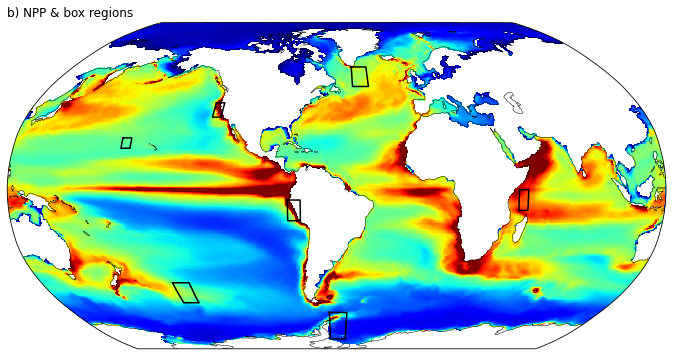

In [26]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) NPP & box regions', fontsize=12,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds2.photoC_TOT_zint * 86400.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 vmin=0,vmax=60,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box7_lonmin,box7_lonmax,box7_lonmax,box7_lonmin,box7_lonmin]
lat_pts = [box7_latmax,box7_latmax,box7_latmin,box7_latmin,box7_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree());

### Generate masks for these regions

In [27]:
mask1 = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
mask2 = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
mask3 = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
mask4 = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
mask5 = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons_norm<box5_lonmax).where(lons_norm>box5_lonmin)
mask6 = ones.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)
mask7 = ones.where(lats<box7_latmax).where(lats>box7_latmin).where(lons_norm<box7_lonmax).where(lons_norm>box7_lonmin)

### put them in a dictionary

mask_dict = {'mask1' : mask1, 
             'mask2' : mask2, 
             'mask3' : mask3, 
             'mask4' : mask4, 
             'mask5' : mask5, 
             'mask6' : mask6, 
             'mask7' : mask7}

### Make area-weighted averages for monthly climatology - 2D vars

In [28]:
ts_monclim_dict = {}

for reg in ['1','2','3','4','5','6','7']:

    ts = xr.Dataset()
    
    mask = mask_dict['mask'+reg]

    for v in variables2d:
        
        masked_area = area.where(mask==1)
        masked_fosi = cesm_mon_ds2[v].where(mask==1)
        ts[v] = (masked_fosi * masked_area).sum(dim=('xh','yh')) / masked_area.sum(dim=('xh','yh'))

    ts_monclim_dict['box'+reg] = ts
    


###  Make area-weighted averages for monthly climatology for certain 3D vars

In [29]:
%%time

ts_monclim_dict_3d = {}

for reg in ['1','2','3','4','5','6','7']:

    print('doing region', reg)
    ts = xr.Dataset()
    
    mask = mask_dict['mask'+reg]

    for v in variables3d:
        
        masked_area = area_depth.where(mask==1)
        masked_fosi = cesm_mon_ds[v].where(mask==1)
        ts[v] = (masked_fosi * masked_area).sum(dim=('xh','yh')) / masked_area.sum(dim=('xh','yh'))

    ts_monclim_dict_3d['box'+reg] = ts.compute()
    


doing region 1
doing region 2
doing region 3
doing region 4
doing region 5
doing region 6
doing region 7
CPU times: user 2min 4s, sys: 4.99 s, total: 2min 9s
Wall time: 5min 37s


### Make annual mean values for 3-D variables

In [30]:
%%time

ts_annmean_dict_3d = {}

for reg in ['1','2','3','4','5','6','7']:

    print('doing region', reg)
    ts = xr.Dataset()
    
    mask = mask_dict['mask'+reg]

    for v in variables3d:
        
        masked_area = area_depth.where(mask==1)
        masked_fosi = cesm_ann_ds[v].where(mask==1)
        ts[v] = (masked_fosi * masked_area).sum(dim=('xh','yh')) / masked_area.sum(dim=('xh','yh'))

    ts_annmean_dict_3d['box'+reg] = ts.compute()
    


doing region 1
doing region 2
doing region 3
doing region 4
doing region 5
doing region 6
doing region 7
CPU times: user 6.13 s, sys: 2.42 s, total: 8.55 s
Wall time: 9.05 s


### Make phytoplanktion biomass depth profiles for monthly climatology

In [31]:
colors = ['lightcoral','red','darkorange','gold','lightgreen','green','darkturquoise','dodgerblue','blue','darkviolet','magenta','hotpink']
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
xvals = np.arange(1,13,1)
depths = cesm_mon_ds.z_l

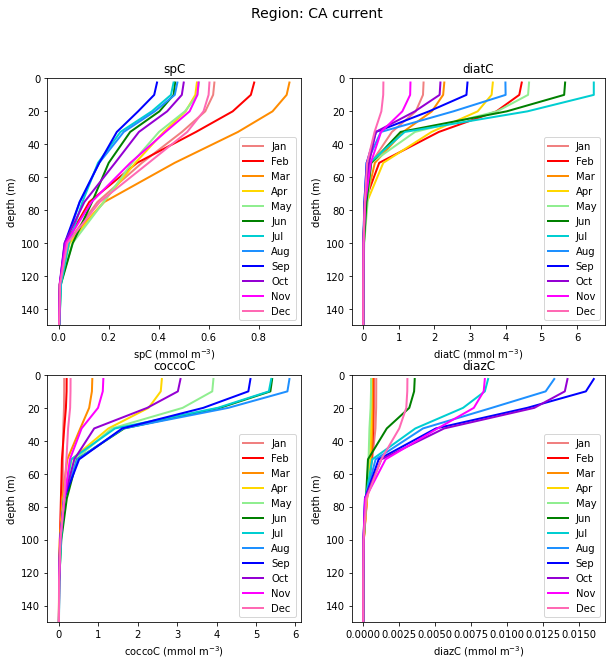

-----------------------------------------------------------------------------


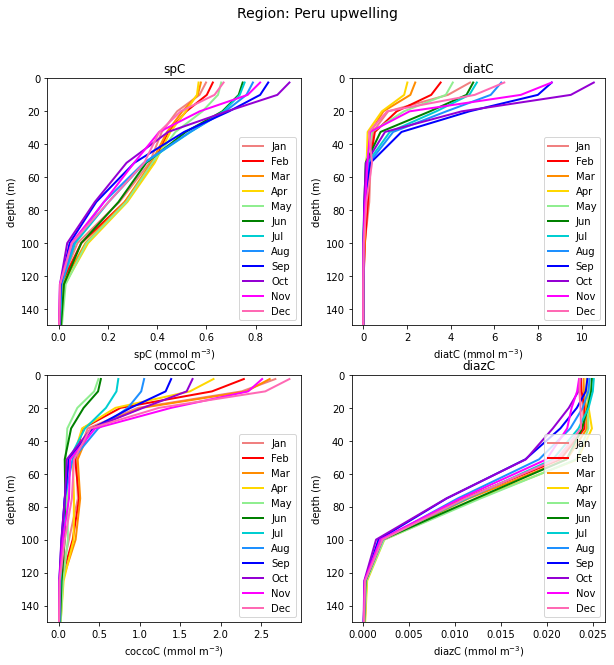

-----------------------------------------------------------------------------


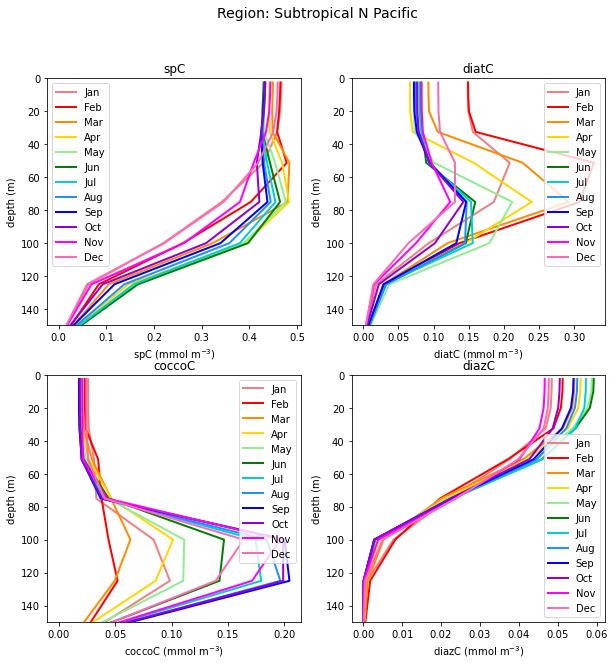

-----------------------------------------------------------------------------


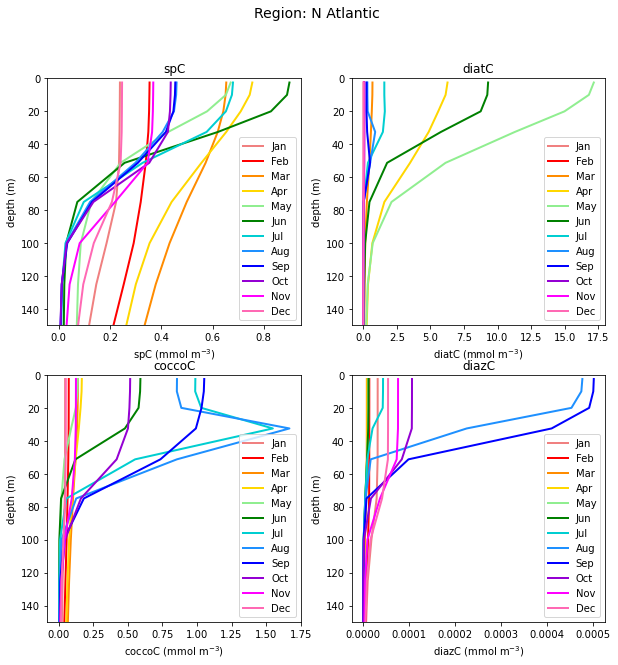

-----------------------------------------------------------------------------


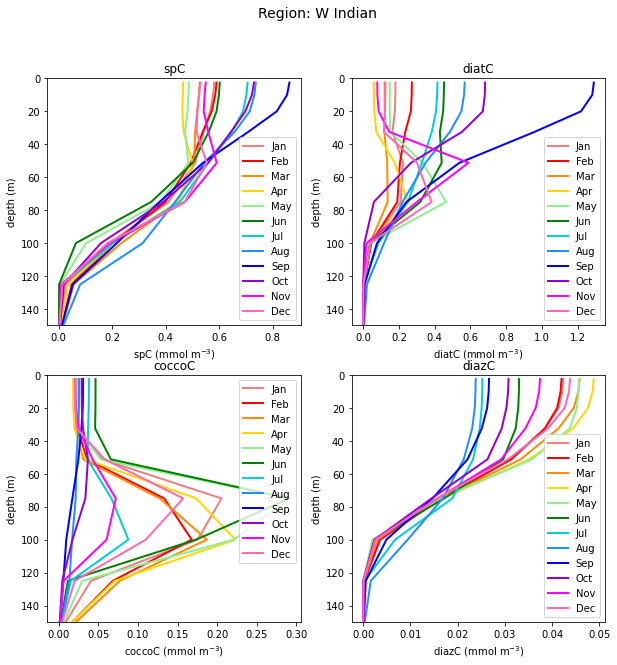

-----------------------------------------------------------------------------


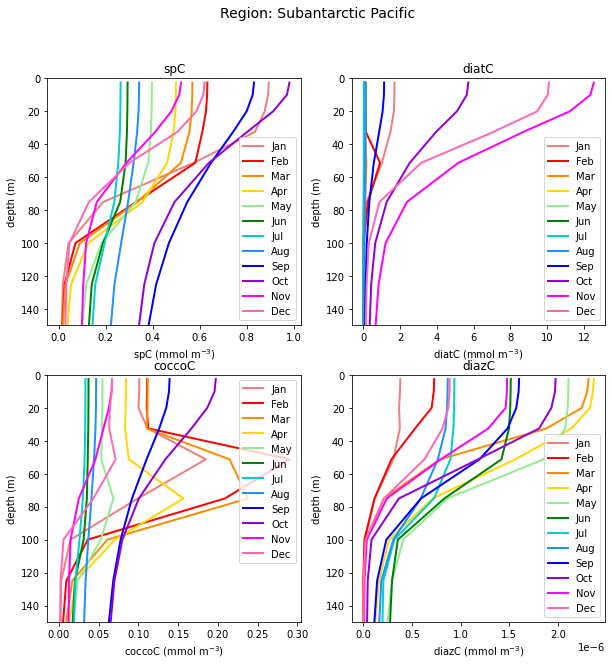

-----------------------------------------------------------------------------


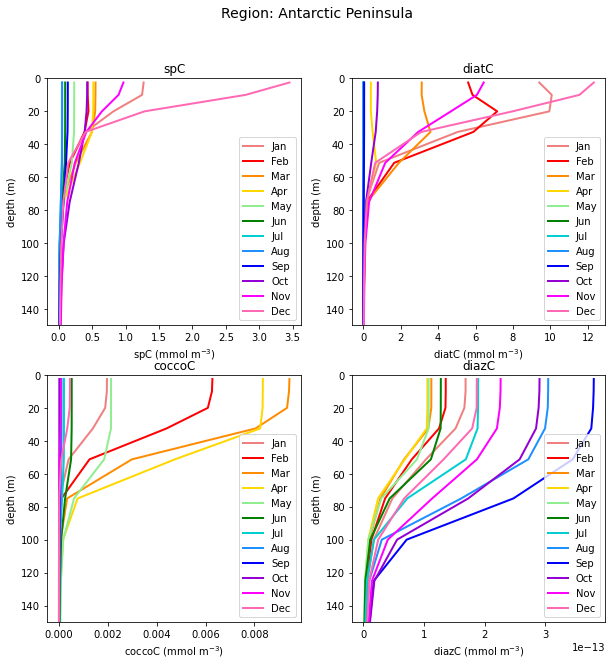

-----------------------------------------------------------------------------


In [32]:
for reg in ['1','2','3','4','5','6','7']:

    plot = 1
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Region: ' + reg_name_dict['box'+reg],fontsize=14)


    for var in ['spC','diatC','coccoC','diazC']:
    
        ax = fig.add_subplot(2,2,plot)
        ax.set_title(var)
        
        for month in np.arange(0,12,1):
            
            ax.plot(ts_monclim_dict_3d['box'+reg][var].isel(month=month), depths, 
                    label=xlabels[month], linewidth=2, color = colors[month])
        
        ax.set_ylim(0,150)
        ax.legend()
        ax.set(ylabel='depth (m)',xlabel= var + ' (mmol m$^{-3}$)')
        plt.gca().invert_yaxis()
        
        plot = plot + 1

    plt.show()

    print('-----------------------------------------------------------------------------')
    

### Same plots as above, but with Chlorophyll

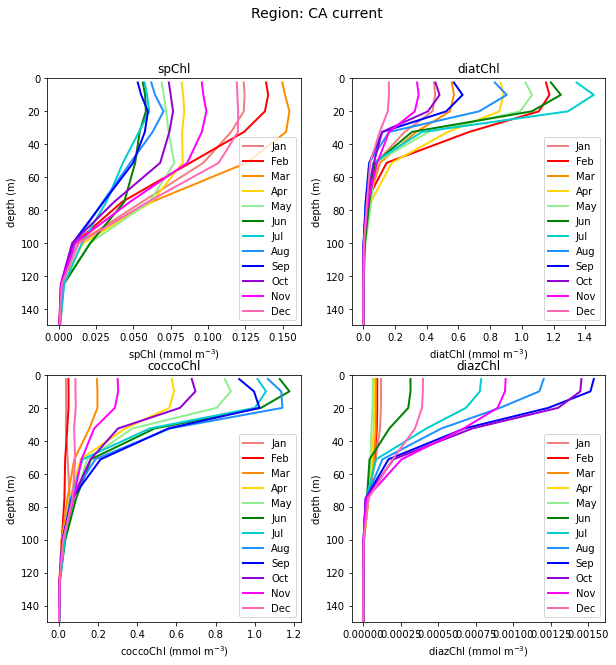

-----------------------------------------------------------------------------


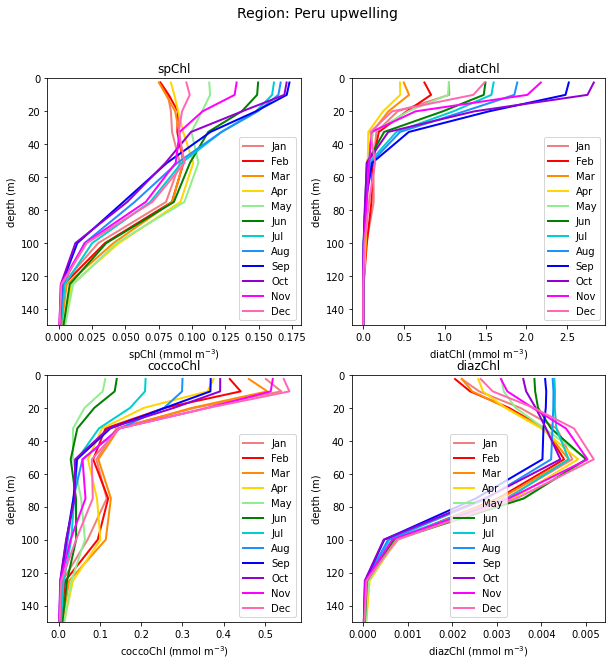

-----------------------------------------------------------------------------


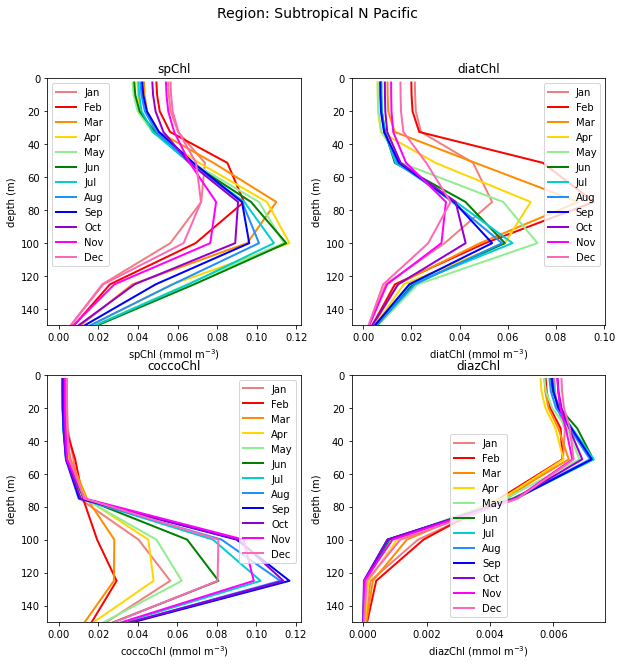

-----------------------------------------------------------------------------


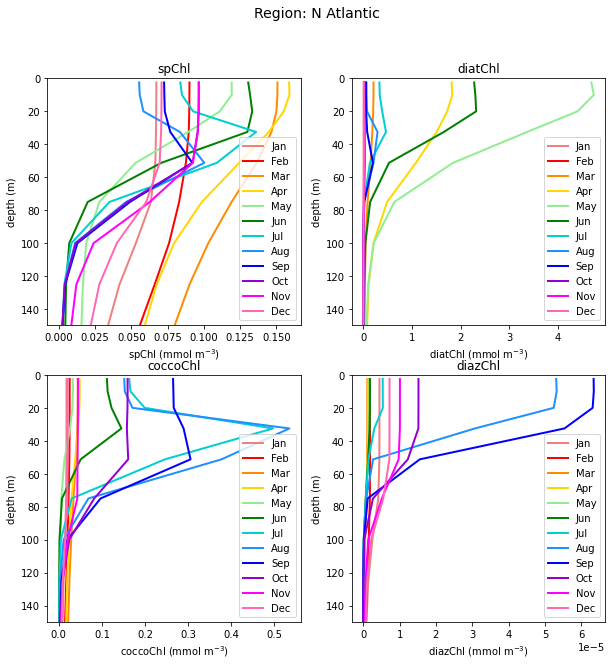

-----------------------------------------------------------------------------


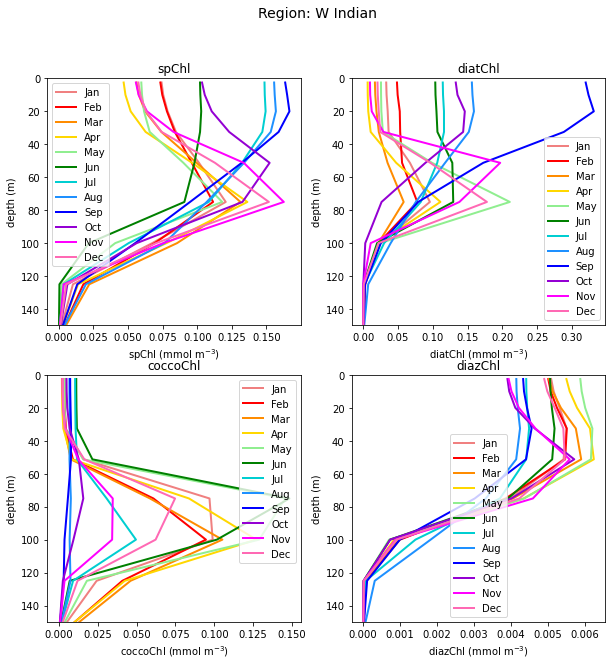

-----------------------------------------------------------------------------


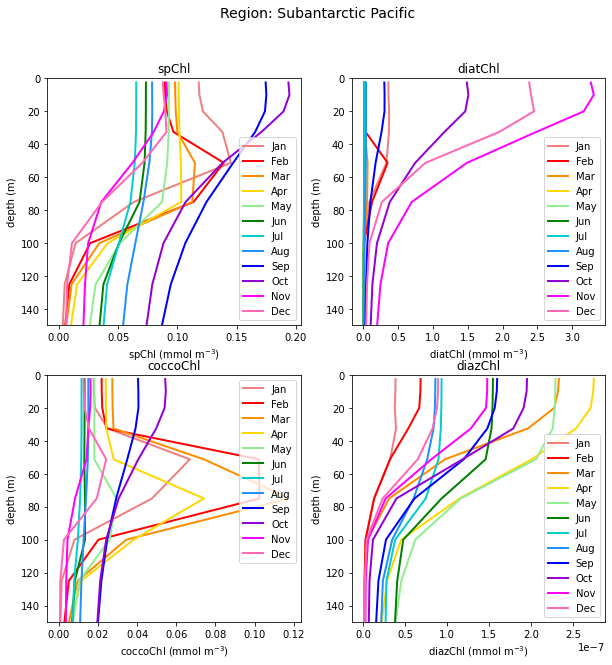

-----------------------------------------------------------------------------


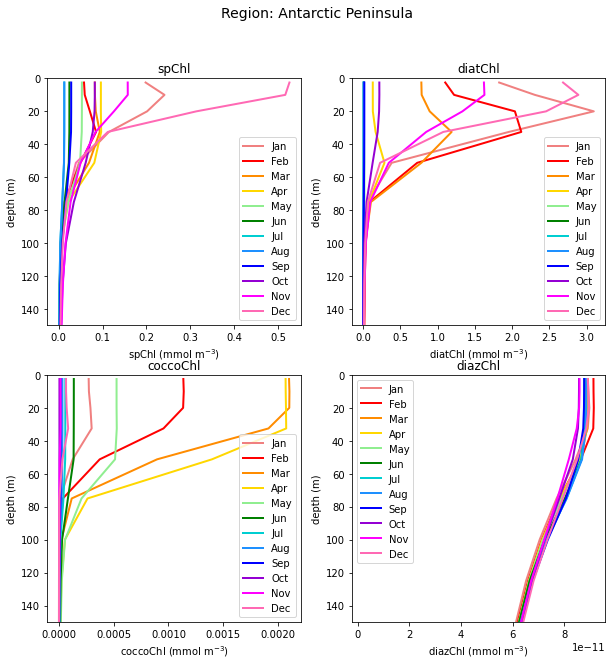

-----------------------------------------------------------------------------


In [33]:
for reg in ['1','2','3','4','5','6','7']:

    plot = 1
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Region: ' + reg_name_dict['box'+reg],fontsize=14)


    for var in ['spChl','diatChl','coccoChl','diazChl']:
    
        ax = fig.add_subplot(2,2,plot)
        ax.set_title(var)
        
        for month in np.arange(0,12,1):
            
            ax.plot(ts_monclim_dict_3d['box'+reg][var].isel(month=month), depths, 
                    label=xlabels[month], linewidth=2, color = colors[month])
        
        ax.set_ylim(0,150)
        ax.legend()
        ax.set(ylabel='depth (m)',xlabel= var + ' (mmol m$^{-3}$)')
        plt.gca().invert_yaxis()
        
        plot = plot + 1

    plt.show()

    print('-----------------------------------------------------------------------------')
    

## Compare macronutrients to World Ocean Atlas 2018 and Fe to GEOTRACES+

In [34]:
path = '/glade/work/kristenk/WOA_data'

files = [path+'/woa18_all_n00_01.nc', 
         path+'/woa18_all_p00_01.nc',
         path+'/woa18_all_i00_01.nc',
         path+'/woa18_all_o00_01.nc',
         #path+'/woa18_decav_t00_01.nc', #I took out these physical variables cause they added an extra time dim
         #path+'/woa18_decav_s00_01.nc'
        ]
ds_woa = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

In [35]:
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')
df['lons_norm'] = (df['lon'] - 360).where(df.lon > 180, other=df.lon)
df

,lon,lat,depth,dFe_obs,lons_norm
0,210.010,-16.0018,20.0,0.540000,-149.990
1,210.010,-16.0018,35.0,0.440000,-149.990
2,210.010,-16.0019,50.0,0.480000,-149.990
3,210.010,-16.0019,80.0,0.400000,-149.990
4,210.010,-16.0020,100.0,0.390000,-149.990
...,...,...,...,...,...
27777,160.051,47.0032,3929.6,0.825681,160.051
27778,160.051,47.0032,3929.8,0.902248,160.051
27779,160.051,47.0032,4900.4,0.555630,160.051
27780,160.051,47.0032,4900.9,0.621851,160.051


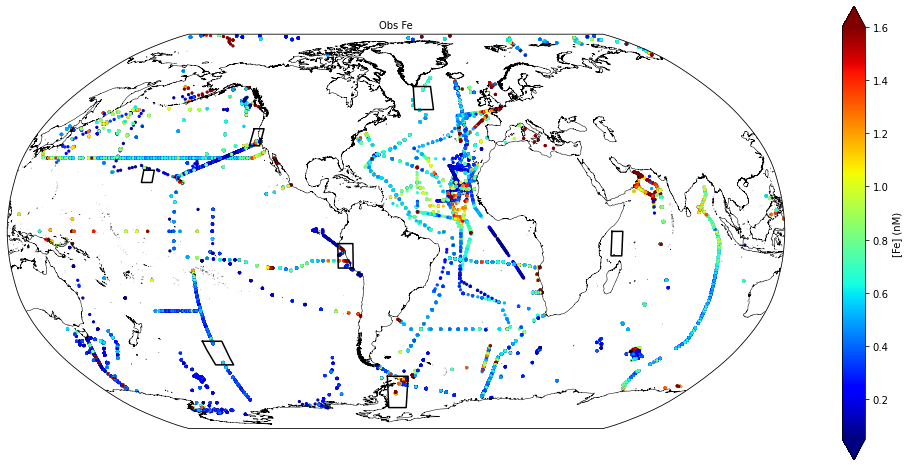

In [36]:
fig = plt.figure(figsize=(16,9))

# ### obs
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe', fontsize=10)

sc = ax.scatter(df.lon, df.lat, c=df.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=1.6, s=5,
                transform=ccrs.PlateCarree())

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box7_lonmin,box7_lonmax,box7_lonmax,box7_lonmin,box7_lonmin]
lat_pts = [box7_latmax,box7_latmax,box7_latmin,box7_latmin,box7_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree());

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(sc, cax=cbar_ax,extend='both',label='[Fe] (nM)')

In [45]:
df_sub1 = df[(df.lat<box1_latmax) & (df.lat>box1_latmin) & (df.lons_norm<box1_lonmax) & (df.lons_norm>box1_lonmin)& (df.dFe_obs<5)]
df_sub2 = df[(df.lat<box2_latmax) & (df.lat>box2_latmin) & (df.lons_norm<box2_lonmax) & (df.lons_norm>box2_lonmin)& (df.dFe_obs<5)]
df_sub3 = df[(df.lat<box3_latmax) & (df.lat>box3_latmin) & (df.lons_norm<box3_lonmax) & (df.lons_norm>box3_lonmin)& (df.dFe_obs<5)]
df_sub4 = df[(df.lat<box4_latmax) & (df.lat>box4_latmin) & (df.lons_norm<box4_lonmax) & (df.lons_norm>box4_lonmin)& (df.dFe_obs<5)]
df_sub5 = df[(df.lat<box5_latmax) & (df.lat>box5_latmin) & (df.lons_norm<box5_lonmax) & (df.lons_norm>box5_lonmin)& (df.dFe_obs<5)]
df_sub6 = df[(df.lat<box6_latmax) & (df.lat>box6_latmin) & (df.lons_norm<box6_lonmax) & (df.lons_norm>box6_lonmin)& (df.dFe_obs<5)]
df_sub7 = df[(df.lat<box7_latmax) & (df.lat>box7_latmin) & (df.lons_norm<box7_lonmax) & (df.lons_norm>box7_lonmin)& (df.dFe_obs<5)]

iron_reg_df_dict = {'mask1' : df_sub1, 
             'mask2' : df_sub2, 
             'mask3' : df_sub3, 
             'mask4' : df_sub4, 
             'mask5' : df_sub5, 
             'mask6' : df_sub6, 
             'mask7' : df_sub7}

### Calculate grid cell area on the WOA grid (regular 1° lon/lat)

In [46]:
a = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

j=0

for lat in ds_woa.lat.values:

    pi     =    3.14159265359
    radius = 6378.137
    deg2rad = pi / 180.0
    resolution_lat =1 #res in degrees
    resolution_lon =1 #res in degrees
    elevation = deg2rad * (lat + (resolution_lat / 2.0))
    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat
    a[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    j = j + 1

ds_woa['area']=a

In [47]:
woa_ones = xr.DataArray(np.ones([180,360]), dims=('lat','lon'))
woa_ones = woa_ones.where(ds_woa.n_an > 0)
depths_woa = ds_woa.depth.squeeze()
area_depth_woa = ds_woa.area.where(ds_woa.n_an > 0).squeeze()

In [48]:
mask1 = woa_ones.where(ds_woa.lat<box1_latmax).where(ds_woa.lat>box1_latmin).where(ds_woa.lon<box1_lonmax).where(ds_woa.lon>box1_lonmin)
mask2 = woa_ones.where(ds_woa.lat<box2_latmax).where(ds_woa.lat>box2_latmin).where(ds_woa.lon<box2_lonmax).where(ds_woa.lon>box2_lonmin)
mask3 = woa_ones.where(ds_woa.lat<box3_latmax).where(ds_woa.lat>box3_latmin).where(ds_woa.lon<box3_lonmax).where(ds_woa.lon>box3_lonmin)
mask4 = woa_ones.where(ds_woa.lat<box4_latmax).where(ds_woa.lat>box4_latmin).where(ds_woa.lon<box4_lonmax).where(ds_woa.lon>box4_lonmin)
mask5 = woa_ones.where(ds_woa.lat<box5_latmax).where(ds_woa.lat>box5_latmin).where(ds_woa.lon<box5_lonmax).where(ds_woa.lon>box5_lonmin)
mask6 = woa_ones.where(ds_woa.lat<box6_latmax).where(ds_woa.lat>box6_latmin).where(ds_woa.lon<box6_lonmax).where(ds_woa.lon>box6_lonmin)
mask7 = woa_ones.where(ds_woa.lat<box7_latmax).where(ds_woa.lat>box7_latmin).where(ds_woa.lon<box7_lonmax).where(ds_woa.lon>box7_lonmin)

### put them in a dictionary

mask_dict_woa = {'mask1' : mask1, 
             'mask2' : mask2, 
             'mask3' : mask3, 
             'mask4' : mask4, 
             'mask5' : mask5, 
             'mask6' : mask6, 
             'mask7' : mask7}

### make area-weighted averages for WOA vars: SiO3, NO3, PO4, O2

In [49]:
woa_vars = ['i_an','n_an','o_an','p_an']

ts_annmean_dict_woa = {}

for reg  in ['1','2','3','4','5','6','7']:

    print('doing region', reg)
    ts = xr.Dataset()
    
    mask = mask_dict_woa['mask'+reg]
    
    for v in woa_vars:
        
        masked_area = area_depth_woa.where(mask==1)
        masked_fosi = ds_woa[v].where(mask==1)
        ts[v] = (masked_fosi * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

    ts_annmean_dict_woa['box'+reg] = ts.squeeze().compute()
    


doing region 1
doing region 2
doing region 3
doing region 4
doing region 5
doing region 6
doing region 7


### Nutrient profiles

In [50]:
iron_reg_df_dict['mask1']

,lon,lat,depth,dFe_obs,lons_norm
6591,237.78,36.41,2.0,1.60,-122.22
6592,237.78,36.41,2.0,0.91,-122.22
6593,237.78,36.41,2.0,0.54,-122.22
6594,237.78,36.41,2.0,0.75,-122.22
6595,237.78,36.41,2.0,0.56,-122.22
...,...,...,...,...,...
13267,237.62,36.70,1.0,0.13,-122.38
13268,237.62,36.70,1.0,0.43,-122.38
13269,237.62,36.70,1.0,0.37,-122.38
13270,237.62,36.70,1.0,0.35,-122.38


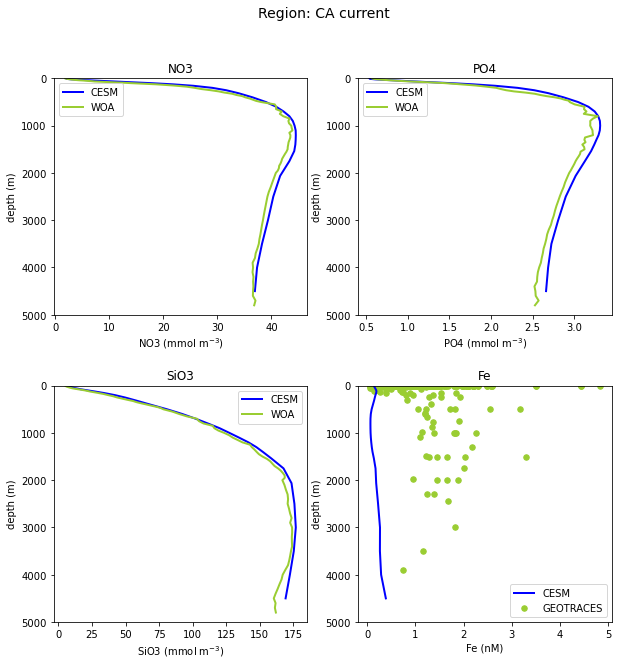

-----------------------------------------------------------------------------


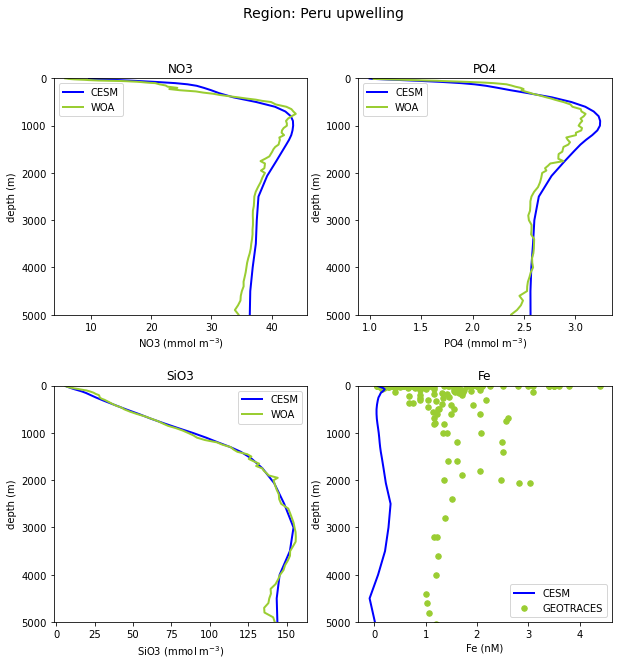

-----------------------------------------------------------------------------


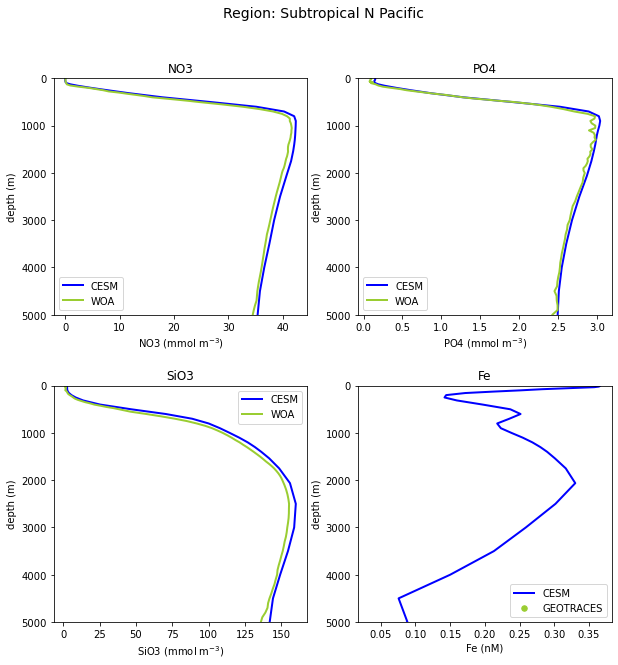

-----------------------------------------------------------------------------


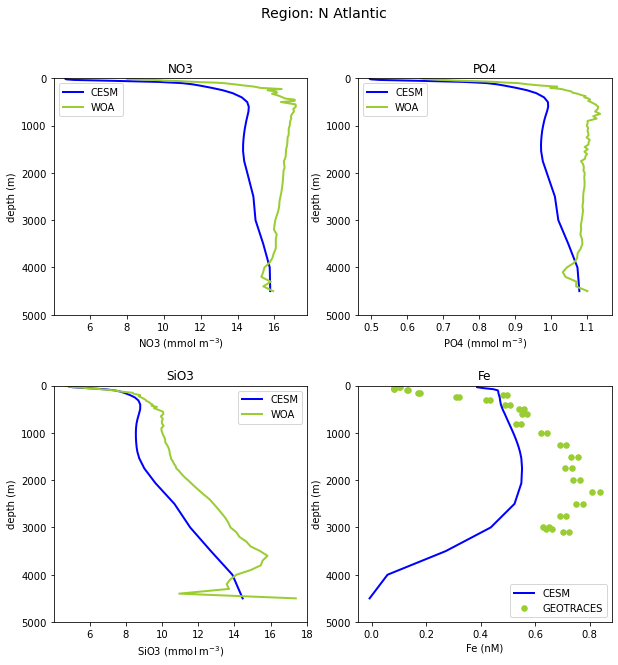

-----------------------------------------------------------------------------


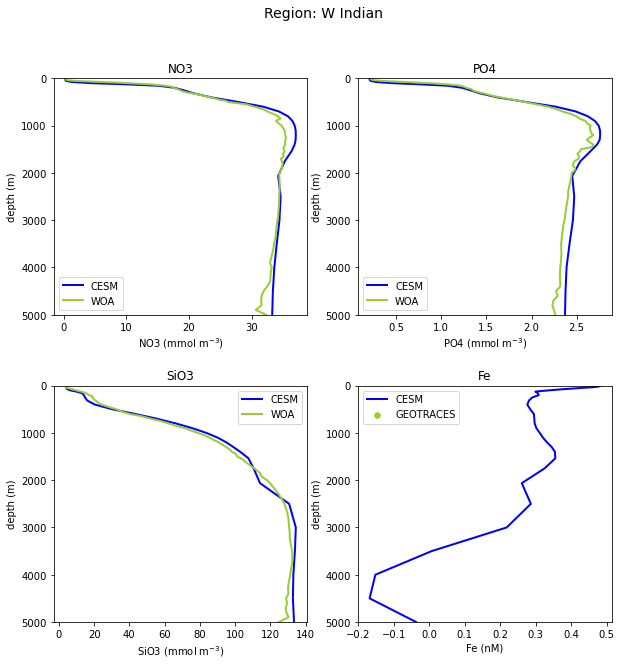

-----------------------------------------------------------------------------


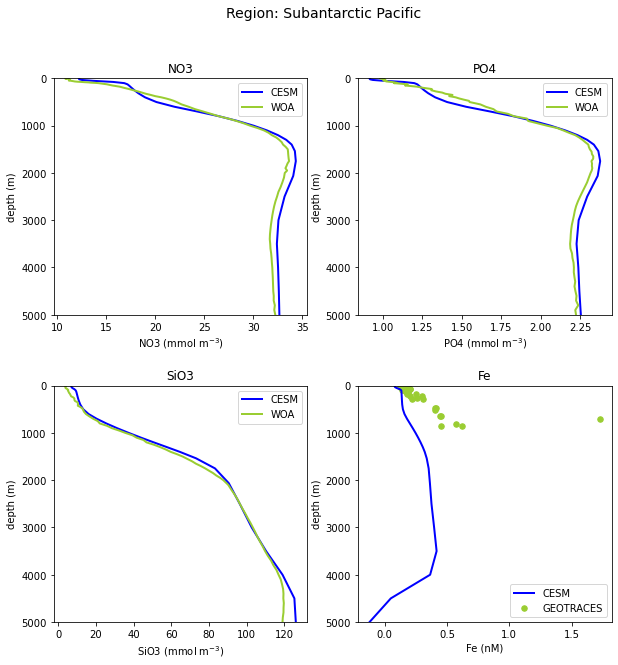

-----------------------------------------------------------------------------


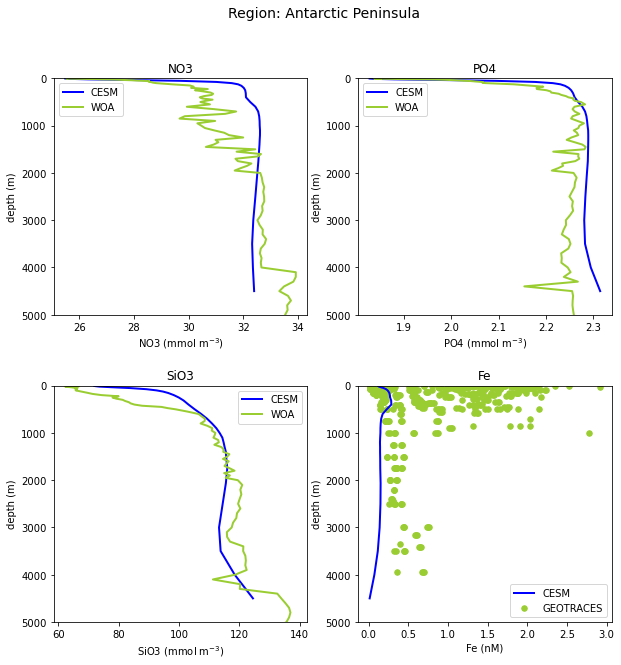

-----------------------------------------------------------------------------


In [51]:
for reg in ['1','2','3','4','5','6','7']:

    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Region: ' + reg_name_dict['box'+reg], fontsize=14)
    
    ax = fig.add_subplot(2,2,1)
    var = 'NO3'
    ax.set_title(var)
    ax.plot(ts_annmean_dict_3d['box'+reg][var], depths, 
            label='CESM', linewidth=2, color = 'blue')
    ax.plot(ts_annmean_dict_woa['box'+reg]['n_an'], depths_woa, 
            label='WOA', linewidth=2, color = 'yellowgreen')
    ax.legend()
    ax.set_ylim(0,5000)
    ax.set(ylabel='depth (m)',xlabel= var + ' (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()

    ax = fig.add_subplot(2,2,2)
    var = 'PO4'
    ax.set_title(var)
    ax.plot(ts_annmean_dict_3d['box'+reg][var], depths, 
            label='CESM', linewidth=2, color = 'blue')
    ax.plot(ts_annmean_dict_woa['box'+reg]['p_an'], depths_woa, 
            label='WOA', linewidth=2, color = 'yellowgreen')
    ax.legend()
    ax.set_ylim(0,5000)
    ax.set(ylabel='depth (m)',xlabel= var + ' (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()

    ax = fig.add_subplot(2,2,3)
    var = 'SiO3'
    ax.set_title(var)
    ax.plot(ts_annmean_dict_3d['box'+reg][var], depths, 
            label='CESM', linewidth=2, color = 'blue')
    ax.plot(ts_annmean_dict_woa['box'+reg]['i_an'], depths_woa, 
            label='WOA', linewidth=2, color = 'yellowgreen')
    ax.legend()
    ax.set_ylim(0,5000)
    ax.set(ylabel='depth (m)',xlabel= var + ' (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()

    ax = fig.add_subplot(2,2,4)
    var = 'Fe'
    ax.set_title(var)
    ax.plot(ts_annmean_dict_3d['box'+reg][var]*1000, depths, 
            label='CESM', linewidth=2, color = 'blue')
    ax.scatter(iron_reg_df_dict['mask'+reg].dFe_obs,iron_reg_df_dict['mask'+reg].depth,color='yellowgreen',s=30, label='GEOTRACES')
    ax.legend()
    ax.set_ylim(0,5000)
    ax.set(ylabel='depth (m)',xlabel= var + ' (nM)')
    plt.gca().invert_yaxis()

    fig.subplots_adjust(hspace=0.3)
    
    plt.show()

    print('-----------------------------------------------------------------------------')
    

In [106]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
